In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import xgboost as xgb

%matplotlib inline

/home/gpk/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [22]:
tournamentdf = pd.read_csv('numerai_tournament_data.csv')

In [18]:
traindf = pd.read_csv('numerai_training_data.csv')

In [19]:
X = traindf.drop(['era','data_type','id','target'],axis=1)
y = traindf['target']

In [20]:
X.shape,y.shape

((108405, 21), (108405,))

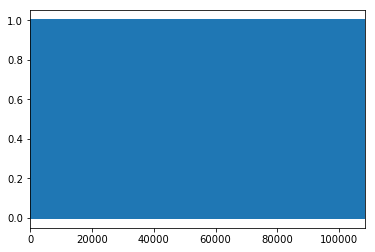

In [23]:
y.plot()

In [71]:
clf = xgb.XGBClassifier(n_estimators=1000,learning_rate=1e-2,subsample=0.8)


In [54]:
X_valid = tournamentdf.drop(['id','era','data_type','target'],axis=1)
y_valid = tournamentdf['target']

In [55]:
X_test = X_valid[pd.isnull(y_valid)]
y_val = y_valid[~pd.isnull(y_valid)]
X_val = X_valid[~pd.isnull(y_valid)]

In [56]:
dtrain = xgb.DMatrix(data=X,feature_names=X.columns,label=y)
dval = xgb.DMatrix(data=X_val,feature_names=X.columns,label=y_val)
dtest = xgb.DMatrix(X_test)

In [72]:
clf.fit(X,y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

In [83]:
val_preds = clf.predict_proba(X_val)

In [84]:
# predictions = clf.predict(X_valid)

In [85]:
from sklearn.metrics import log_loss

In [86]:
log_loss(y_val,val_preds)

0.69263942775452836

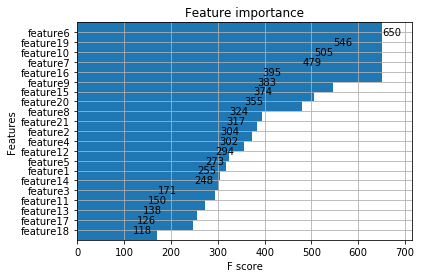

In [82]:
xgb.plot_importance(clf,importance_type='weight',height=10)

In [89]:
def gen_preds(model=clf):
    #Adapted from numerai submission code.
    # Set seed for reproducibility
    np.random.seed(0)

    print("Loading data...")
    # Load the data from the CSV files
    training_data = pd.read_csv('numerai_training_data.csv', header=0)
    prediction_data = pd.read_csv('numerai_tournament_data.csv', header=0)


    # Transform the loaded CSV data into numpy arrays
    features = [f for f in list(training_data) if "feature" in f]
    X = training_data[features]
    Y = training_data["target"]
    x_prediction = prediction_data[features]
    ids = prediction_data["id"]

    # This is your model that will learn to predict
#     model = linear_model.LogisticRegression(n_jobs=-1)

    print("Training...")
    # Your model is trained on the training_data
    model.fit(X, Y)

    print("Predicting...")
    # Your trained model is now used to make predictions on the numerai_tournament_data
    # The model returns two columns: [probability of 0, probability of 1]
    # We are just interested in the probability that the target is 1.
    y_prediction = model.predict_proba(x_prediction)
    results = y_prediction[:, 1]
    results_df = pd.DataFrame(data={'probability':results})
    joined = pd.DataFrame(ids).join(results_df)

    print("Writing predictions to predictions.csv")
    # Save the predictions out to a CSV file
    joined.to_csv("predictions.csv", index=False)

In [90]:
gen_preds()

Loading data...
Training...
Predicting...
Writing predictions to predictions.csv
